# Star Density Unwrapping

This tutorial demonstrates the usage of `circle_bundles` in a situation where the underlying fiber bundle model has fiber $\mathbb{S}^{1}\coprod\mathbb{S}^{1}$. In general, the structure group for such a bundle $\xi$ is $O(2)\rtimes\Sigma_{2}$, and $\xi$ lifts to an ordinary circle bundle over a double cover $\widetilde{B}$ of the base space $B$, determined by a 'permutation class' in $H^{1}(B;\Sigma_{2})$.

We generate a dataset by applying random $SO(3)$ rotations to the vertices of a star pyramid mesh with 5-fold rotational symmetry, then constructing 3D densities from the rotated meshes as in the previous example. Using the same $\mathbb{RP}^{2}$ base projection as was used there, the data over each neighborhood in $\mathbb{RP}^{2}$ in this case is concentrated around a $\textit{pair}$ of disjoint circles. As one might expect, the underlying bundle can be lifted to an ordinary orientable circle bundle over $\mathbb{S}^{2}$ -- one can show that this bundle has Euler number $\pm 10$. 

To capture the global structure, we use fiberwise clustering tools from `circle_bundles` to separate the data over each fiber into component circles and verify the global connectivity. We then lift the base projections to $\mathbb{S}^{2}$ and compute characteristic classes. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import circle_bundles as cb

First, generate the dataset:

In [2]:
#Create the template triangle mesh
mesh = cb.make_star_pyramid(n_points = 5, height = 1)

n_samples = 10000
rng = np.random.default_rng(0)
R = cb.sample_so3(n_samples, rng=rng)[0]  #generate a random sample of SO(3)

mesh_data = cb.get_mesh_sample(mesh, R)  #generate the mesh dataset for visualization

grid_size = 32  #density resolution
sigma = 0.05  

data = cb.make_rotated_density_dataset(
    mesh,
    R,
    grid_size = grid_size,
    sigma = sigma,
)


#Create visualization functions for triangle meshes and 3D densities
vis_mesh = cb.make_star_pyramid_visualizer(mesh)
vis_density = cb.make_density_visualizer(grid_size=grid_size)

Densities are stored as vectors of length $32^{3} = 32768$.  For visualization, the original meshes are stored as vectors of length $11\times 3 = 33$.



View a small sample of the data, represented by 2D projections of the 3D densities and also by the triangle meshes used to produce the densities.

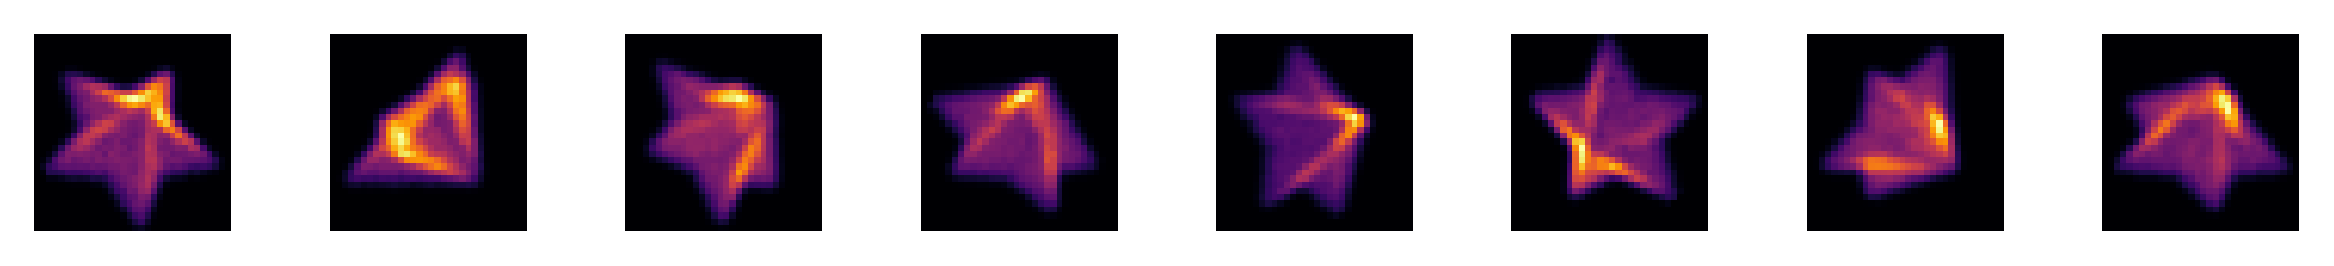

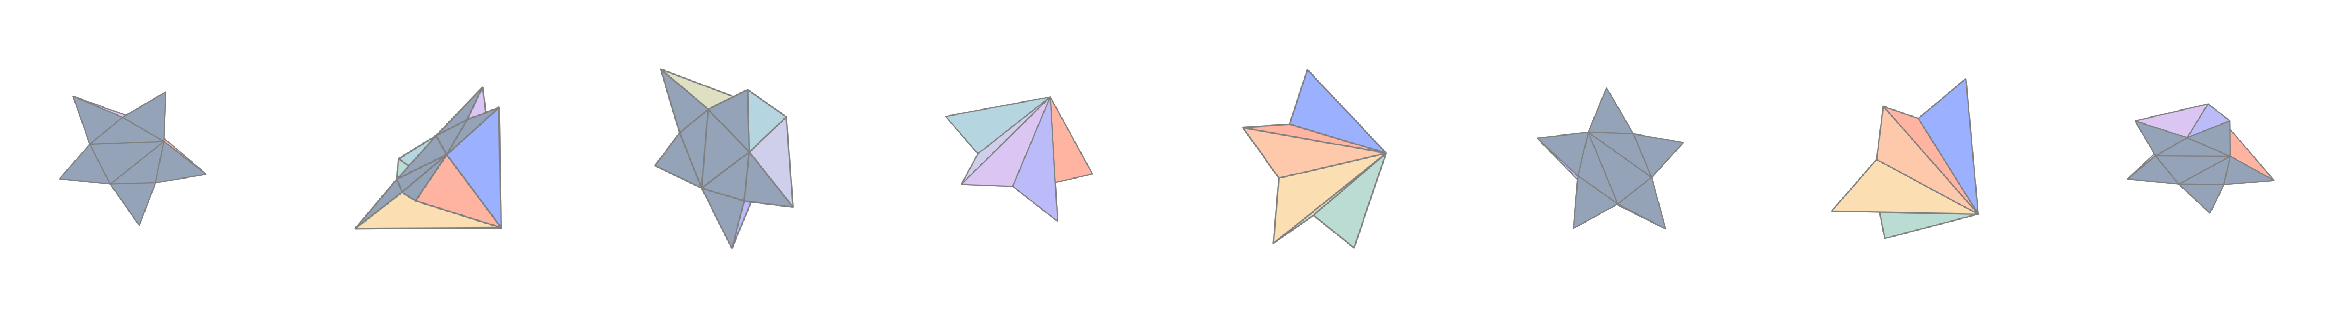

In [3]:
n_to_show = 8
fig = cb.show_data_vis(data, 
                       vis_density, 
                       max_samples = n_to_show, 
                       n_cols = n_to_show, 
                       sampling_method = 'first')
plt.show()


fig = cb.show_data_vis(mesh_data, 
                       vis_mesh, 
                       max_samples = n_to_show, 
                       n_cols = n_to_show, 
                       pad_frac = 0.3, 
                       sampling_method = 'first')
plt.show()


$\textbf{Note:}$ 2D projections of the 3D densities are computed by summing intensities along the z-axis, shown here as perpendicular to the screen.  Reflecting a pyramid mesh through the z-axis produces a very different 3D density, but the 2D projections appear the same.  On the other hand, two pyramid meshes which differ by a rotation in the symmetry group yield indistinguishable 3D densities -- this is a genuine symmetry of the dataset.  

Now, compute the base projections of the densities to $\mathbb{RP}^{2}$ (represented as unit vectors in the upper hemisphere of $\mathbb{S}^{2}$):

In [4]:
base_points = cb.get_density_axes(data)

Construct an open cover of $\mathbb{RP}^{2}$ using a collection of nearly equidistant landmark points (see reference section):

### Cover And Nerve Summary
- $n_\text{sets} = 60$, $n_\text{samples} = 10000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 60$
- $\#(\text{1-simplices}) = 177$
- $\#(\text{2-simplices}) = 118$
- *No recorded simplices in dimensions* $\ge 3$

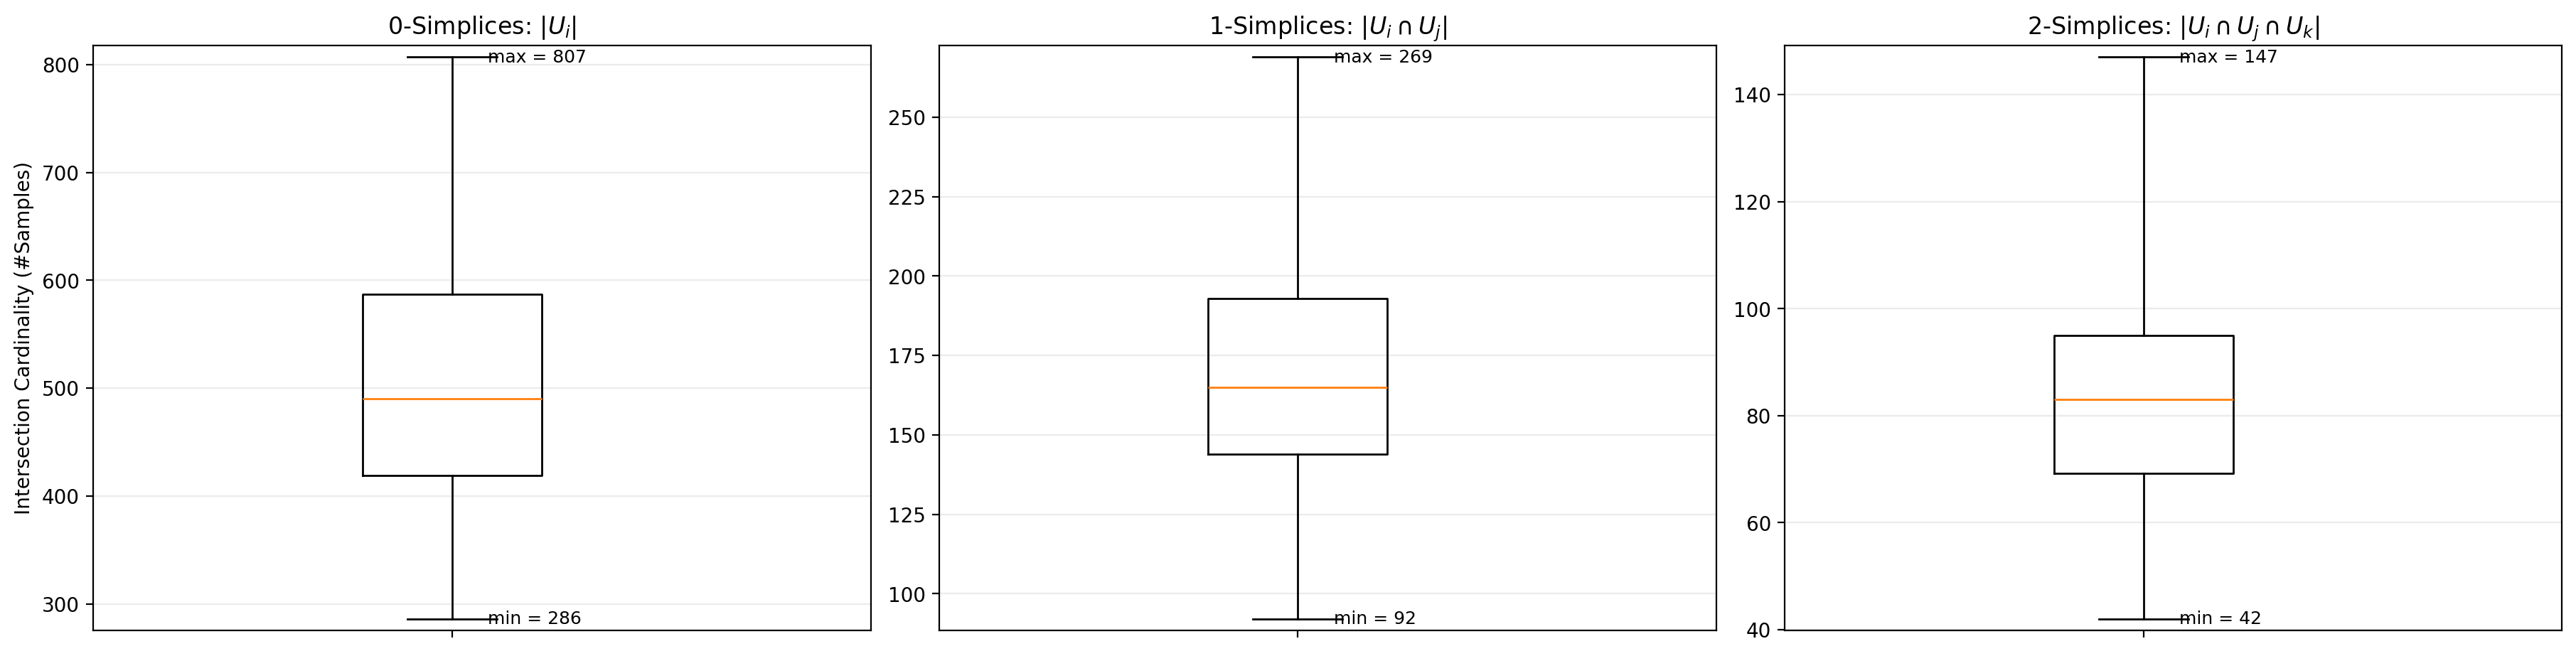

In [5]:
n_landmarks = 60
rp2_cover = cb.get_rp2_fibonacci_cover(base_points, n_pairs = n_landmarks)
rp2_bundle = cb.Bundle(X = data, cover = rp2_cover, show_summary = True)

Note that the nerve of the (good) cover has Euler characteristic $\chi = 60 - 177 + 118 = 1$, which is consistent with $\mathbb{RP}^{2}$.

Optionally run the cell below to view a Plotly visualization of the nerve of the open cover:

In [ ]:
fig = rp2_bundle.show_nerve()

Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$:

/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


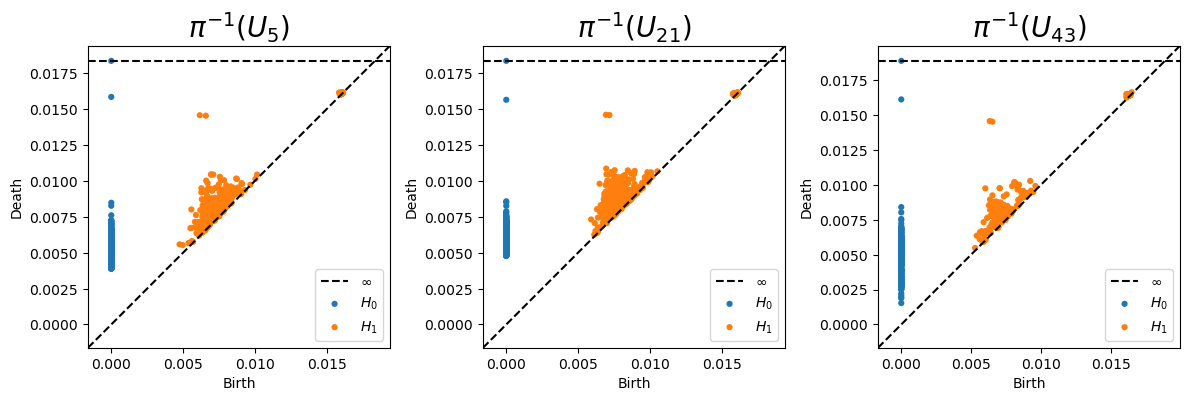

In [6]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    rp2_cover.U,
    to_view = [5,21,43],
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Observe that each set shows a pair of persistent classes in dimensions 0 and 1, suggesting the presence of a pair of local circular clusters in each set. This reflects the fact that the underlying pyramid mesh does not have additional 2-fold symmetry about its rotational axis of symmetry. 

Optionally show a visualization of a 'fat fiber' of the projection map, with densities represented by both 2D projections and the underlying meshes:

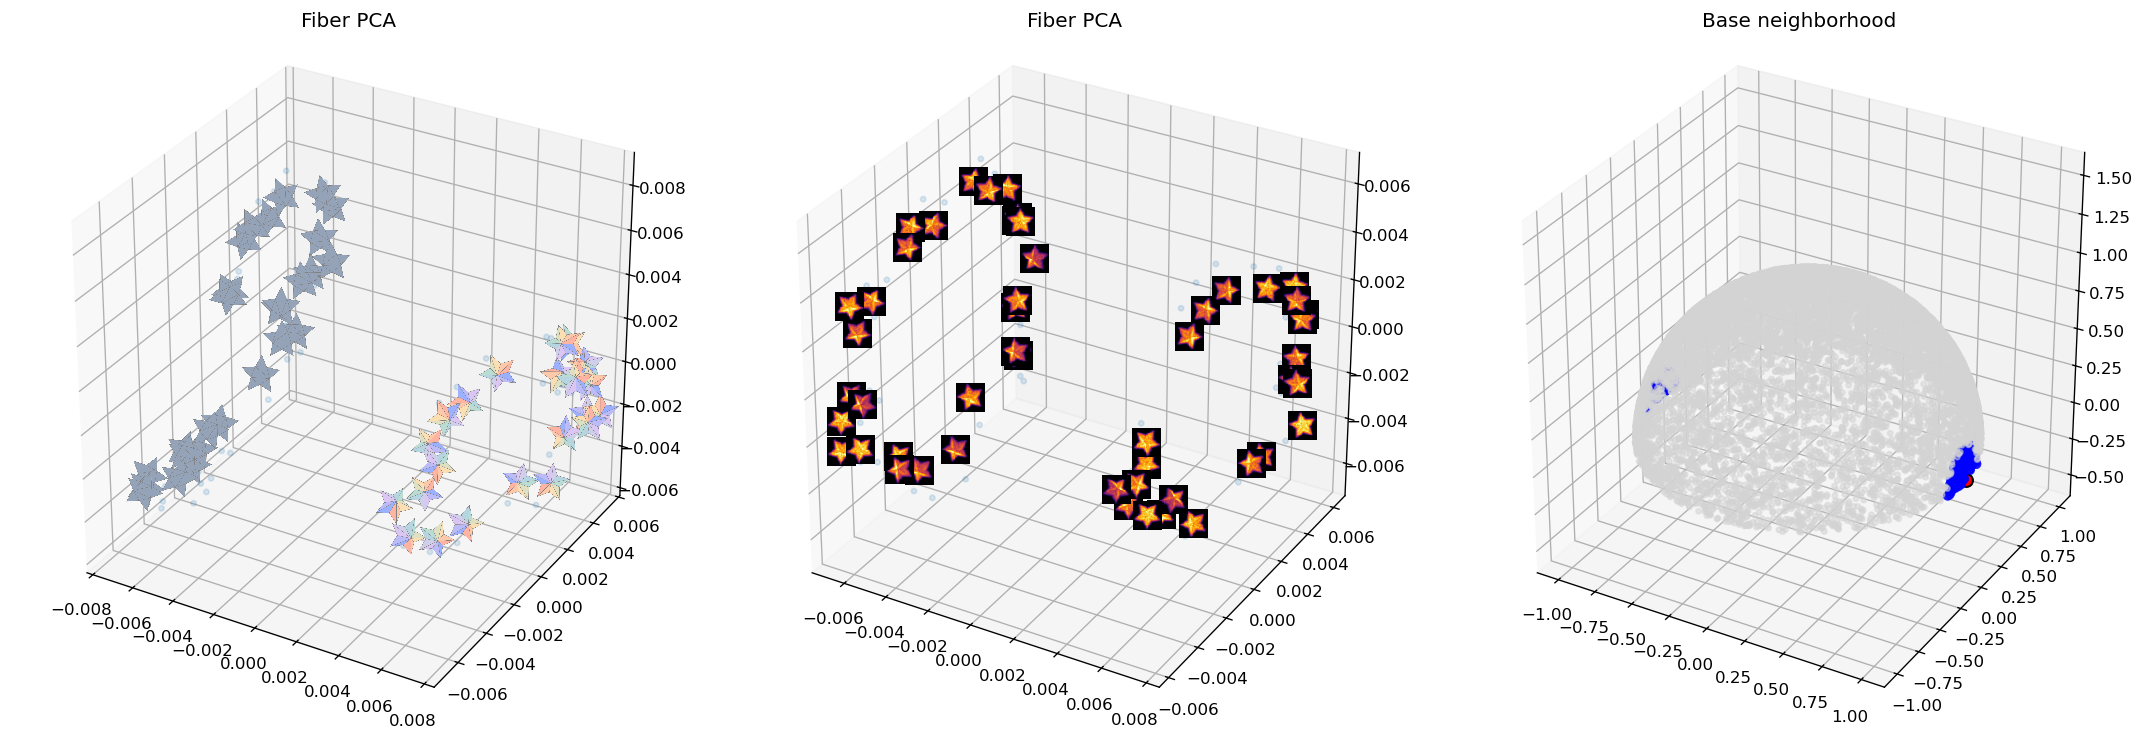

In [7]:
center_ind = 148
r = 0.2
dist_mat = cb.RP2UnitVectorMetric().pairwise(X=base_points)
nearby_indices = np.where(dist_mat[center_ind] < r)[0]

fiber_data = data[nearby_indices]
vis_data = mesh_data[nearby_indices]


fig = plt.figure(figsize=(18, 6), dpi=120)
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

# PCA labeled with meshes
cb.fiber_vis(
    fiber_data,
    vis_mesh,
    vis_data=vis_data,
    max_images=50,
    zoom=0.08,
    ax=ax1,
    show=False,
)
ax1.set_title("Fiber PCA")

# PCA labeled with density projections
cb.fiber_vis(
    fiber_data,
    vis_func=vis_density,
    max_images=50,
    zoom=0.05,
    ax=ax2,
    show=False,
)
ax2.set_title("Fiber PCA")

# Base visualization
cb.base_vis(
    base_points,
    center_ind,
    r,
    dist_mat,
    use_pca=False,
    ax=ax3,
    show=False,
)
ax3.set_title("Base neighborhood")

plt.tight_layout()
plt.show()


Use fiberwise clustering to separate the data in each open set into its two components and track the global connected components:

In [8]:
eps_values = 0.0125*np.ones(len(rp2_cover.U))   #Choose an epsilon value based on 0D persistence diagrams
min_sample_values = 5*np.ones(len(rp2_cover.U))

components, G, graph_dict, cl, summary = cb.fiberwise_clustering(data, 
                                                              rp2_cover.U, 
                                                              eps_values, 
                                                              min_sample_values)

cluster_counts = summary['fiber_component_counts']
print(f'Total number of local clusters: {np.sum(cluster_counts)}')
print(f'Min number of local clusters per fiber: {np.min(cluster_counts)}')
print(f'Max number of local clusters per fiber: {np.max(cluster_counts)}')

print(f'Total number of unclustered points: {np.sum(components == -1)}')
print(f'Total number of global components: {len(np.unique(components[components != -1]))}')


Total number of local clusters: 120
Min number of local clusters per fiber: 2
Max number of local clusters per fiber: 2
Total number of unclustered points: 0
Total number of global clusters: 1


Observe that the data in each fiber was separated into two distinct clusters, but globally, the clusters organize into a single connected component.  This is expected, because the underlying model for the dataset has a single connected component (in particular, the total space is homeomorphic to the lens space $L(10,1)$).

Optionally show the 1-skeleton of the nerve of the cover labeled by the $\Sigma_{2}$-permutation cocycle -- red edges indicate that the local +/- cluster labels are reversed on an overlap, where as blue edges indicate that the local +/- cluster labels agree.  

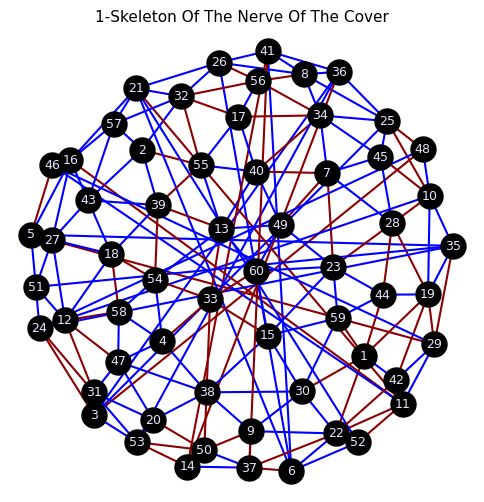

In [9]:
signs = cb.get_cocycle_dict(G)
signs_O1 = {edge:(-1) ** signs[edge] for edge in signs.keys()}

dist_mat = cb.RP2UnitVectorMetric().pairwise(X = rp2_cover.landmarks, Y = base_points)

node_labels = [f"{i+1}" for i in range(rp2_cover.landmarks.shape[0])]

fig, axes = cb.nerve_vis(
    rp2_cover.landmarks[:,:2],
    U = rp2_cover.U,
    cochains={1:signs_O1},
    base_colors={0:'black', 1:'black', 2:'pink'},
    cochain_cmaps={1:{1: 'blue', -1:'darkred'}},
    opacity=0,
    node_size=18,
    line_width=1.5,
    node_labels=node_labels,
    fontsize=9,
    font_color='lavender',
    title='1-Skeleton Of The Nerve Of The Cover'
)

plt.show()

Optionally show a visualization of the local clusters. Each cluster is labeled by the pyramid mesh underlying a  representative 3D density.

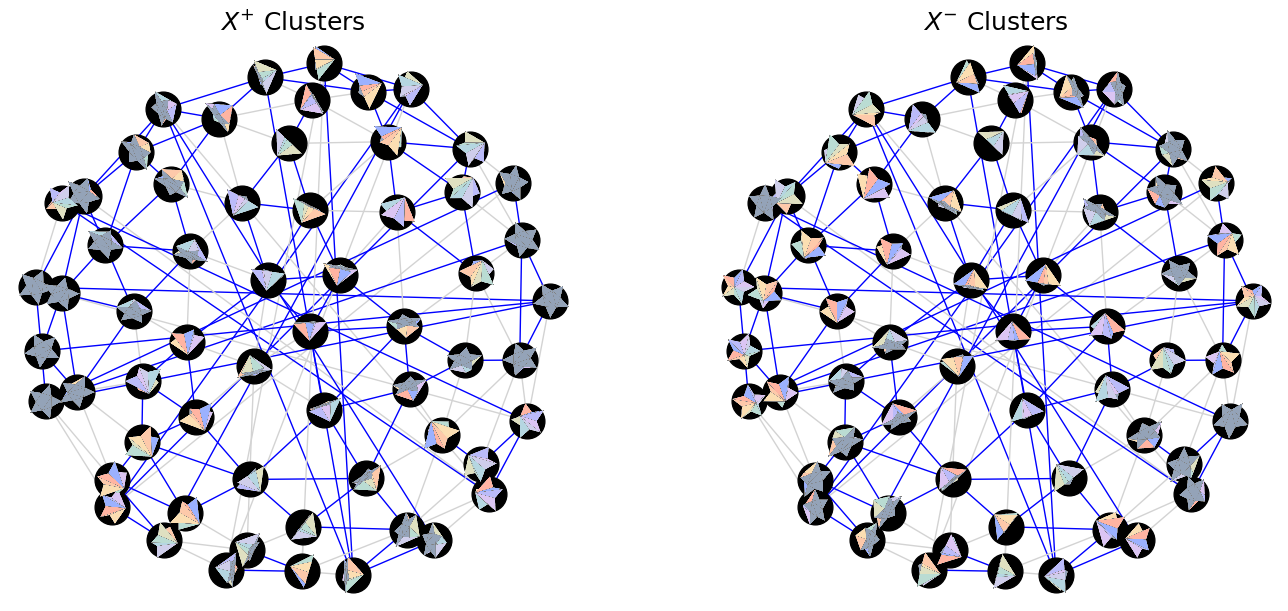

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

for ax, g in zip(axes, [0, 1]):
    sample_inds = []

    # Choose a representative for each cluster with label g
    for node in G.nodes():
        (j, k) = node
        if k == g:
            node_inds = cl[j] == k
            min_idx_local = np.argmin(dist_mat[j, node_inds])
            min_index = np.where(node_inds)[0][min_idx_local]
            sample_inds.append(min_index)

    sample_inds = np.array(sample_inds, dtype=int)

    sample_mesh_data = mesh_data[sample_inds]
    sign = "+" if g == 0 else "-"
    cb.nerve_vis(
        rp2_cover.landmarks[:,:2],
        U = rp2_cover.U,
        cochains={1: signs_O1},
        base_colors={0: "black", 1: "black", 2: "pink"},
        cochain_cmaps={1: {1: "blue", -1: "lightgray"}},
        node_size=25,
        line_width=1,
        node_labels=None,
        fontsize=16,
        font_color="white",
        vis_func=vis_mesh,
        data=sample_mesh_data,
        image_zoom=0.09,
        title = rf"$X^{{{sign}}}$ Clusters",
        ax=ax,                
        show=False,           
    )
fig.savefig('/Users/bradturow/Desktop/Circle Bundle Code/Figures/cluster_graphs.pdf', dpi=300, bbox_inches="tight")

plt.show()


Use the local cluster labels and interchange data on overlaps to lift the base map from $\mathbb{RP}^{2}$ to $\mathbb{S}^{2}$:

### Cover And Nerve Summary
- $n_\text{sets} = 120$, $n_\text{samples} = 10000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 120$
- $\#(\text{1-simplices}) = 354$
- $\#(\text{2-simplices}) = 236$
- *No recorded simplices in dimensions* $\ge 3$

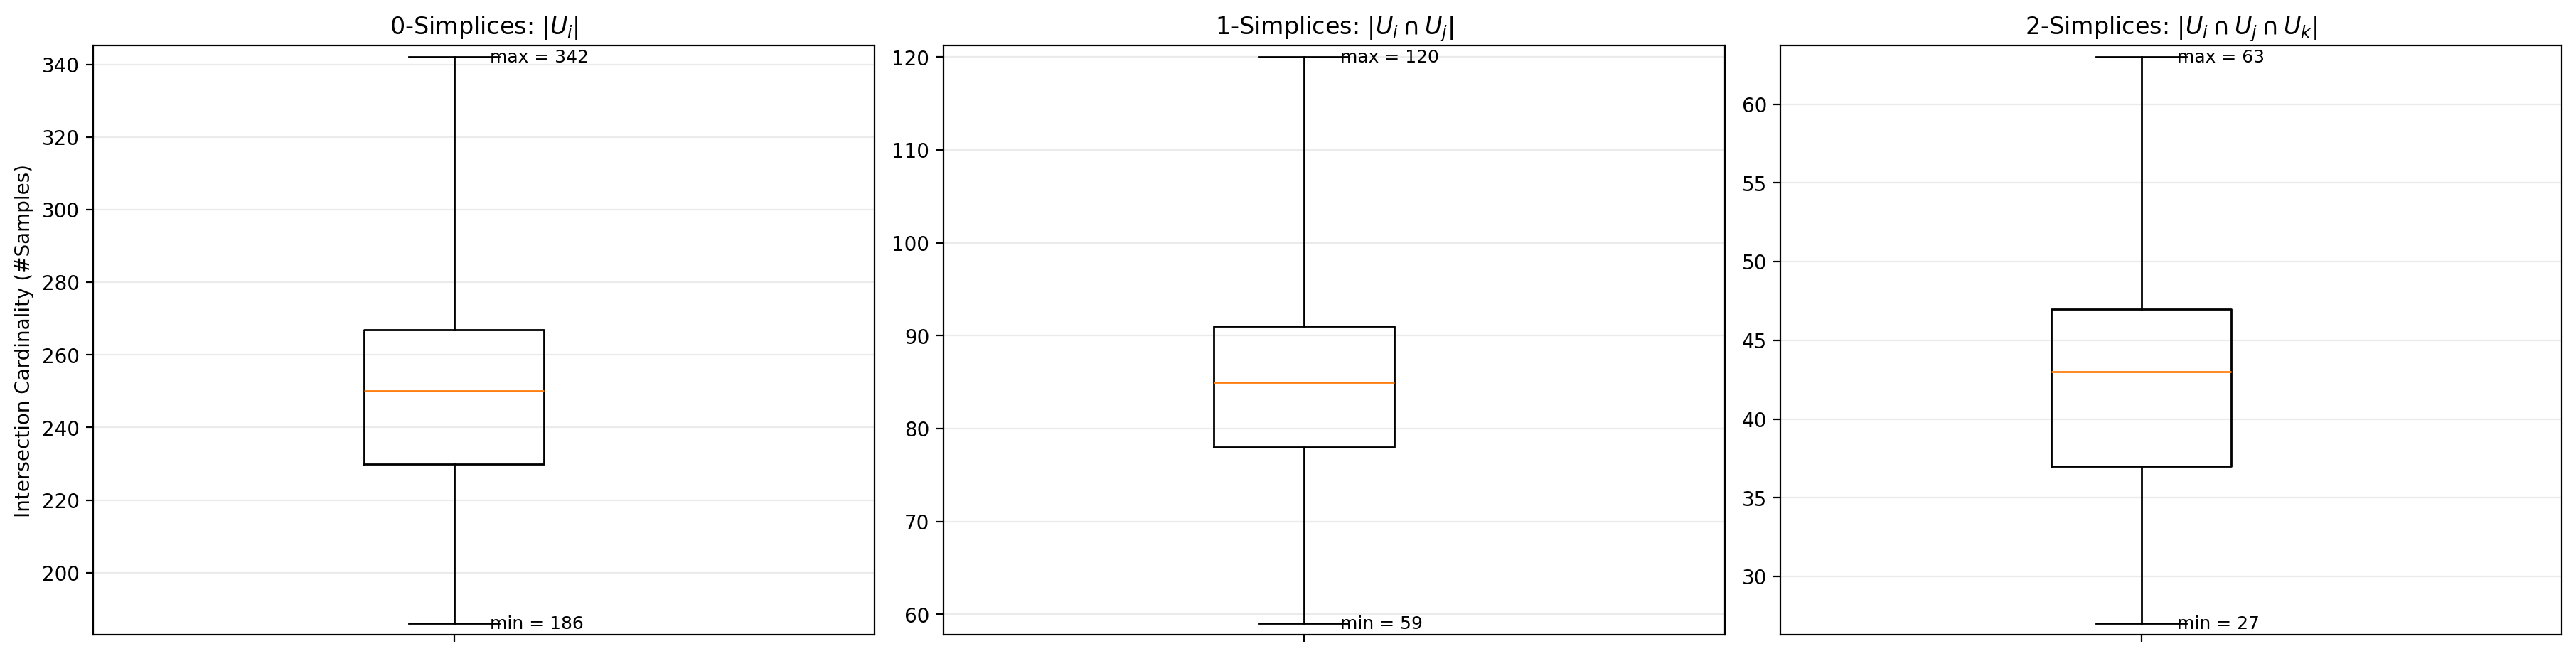

In [12]:
lifted_base_points = cb.lift_base_points(G, cl, base_points)

n_landmarks = 120  #Use more base points this time to compute the local coordinates

s2_cover = cb.get_s2_fibonacci_cover(lifted_base_points, n_vertices = n_landmarks)
s2_bundle = cb.Bundle(data, cover = s2_cover, show_summary = True)

View PCA projections of the fibers of the lifted base map:

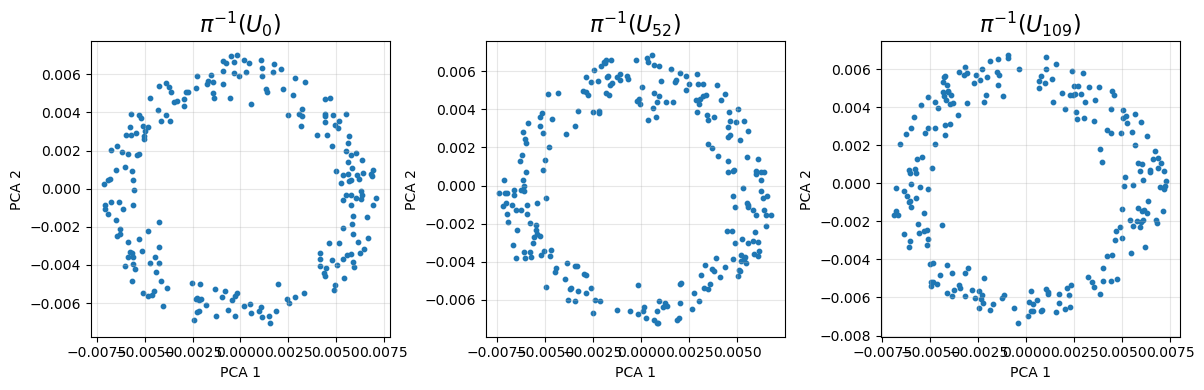

In [17]:
fiber_ids, idx_list, proj_list = cb.get_local_pca(data, s2_cover.U, to_view = [0, 52,109])
fig, axes = cb.plot_local_pca(fiber_ids, proj_list, n_cols = 3)
plt.show()

Compute local trivializations, approximate transition matrices and characteristic classes:

In [18]:
s2_triv_result = s2_bundle.get_local_trivs(show_summary = True)
s2_class_result = s2_bundle.get_classes(show_summary = True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

View some correlations of local circular coordinates on overlaps:

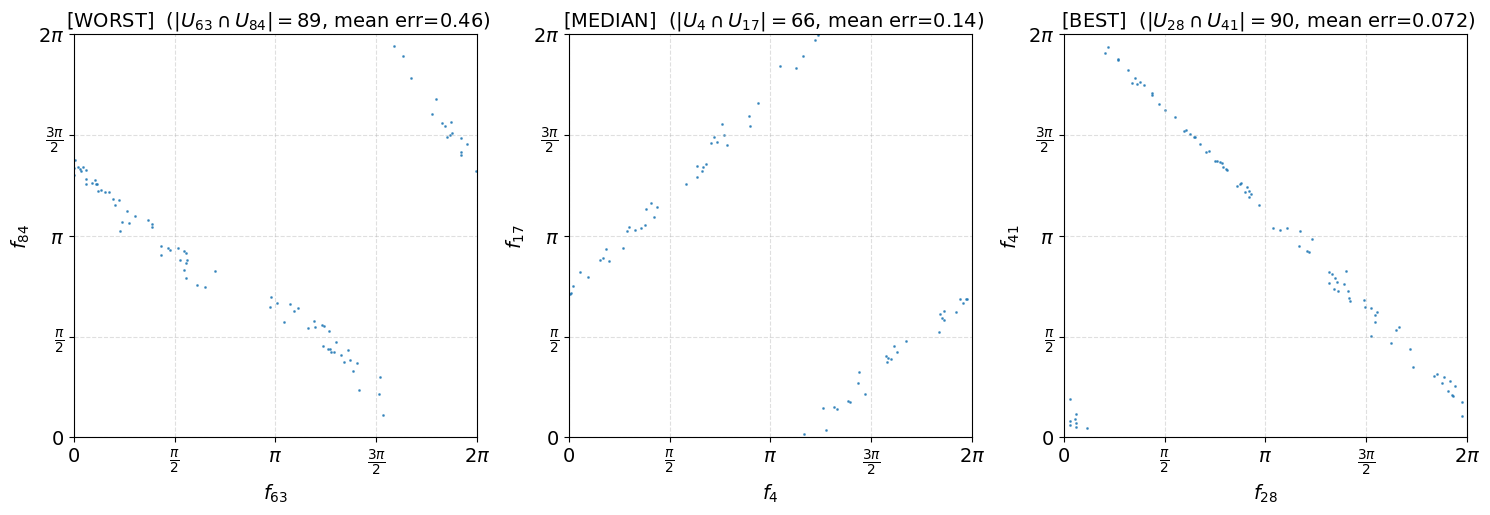

In [19]:
fig = s2_bundle.compare_trivs()
plt.show()